<a href="https://colab.research.google.com/github/MaryTran03/SDS271_final_proj/blob/main/SDS271_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# READme

#Description




In [ ]:
pip install ipympl #Rerun this at the start of every session to make sure the next chunk works

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.5 MB/s eta 0:00:00


In [ ]:
# TO SHOW INTERACTIVE PLOT
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.widgets import RangeSlider
import matplotlib.dates as dt

class IndustryAnalysis:
    def __init__(self, industry, events_file = 'events.csv'):

        # Loading in the raw data to be used later
        self.price_data = pd.read_csv("Prices.csv")
        self.volume_data = pd.read_csv("Volume.csv")

        # Cleaning the dates columns from the data loaded above
        self.price_data['Dates'] = pd.to_datetime(self.price_data['Dates'])
        self.volume_data['Dates'] = pd.to_datetime(self.volume_data['Dates'])

        # ValueErrors to make sure that the industry given in the parameters are in the datasets
        if industry not in self.price_data.columns:
            raise ValueError(f"Industry '{industry}' not found in data. Acceptable industries are: S&P500,Healthcare,Materials,Financials,Consumer Discretionary,Consumer Staples,Information Technology,Utilities,Energy,Industrials, Communication Services")
        else:
            self.industry = industry

        self.events = self.read_event_data(events_file)

        # Adding the attributes for any following figures
        self.length = 12
        self.width = 6
        self.fontsize = 10 # Also use for label size
        self.eventfontsize = 7

    def read_event_data(self, filename):
        """
        A function to read in the events filename and converts strings to datetime. This method is not shown to the user.
        :param filename: the default is a CSV file stored within the package. However the user have an option to load in the event file they want.

        """

        events_df = pd.read_csv(filename)

        # Convert strings to date time objects
        events_df['Start Date'] = pd.to_datetime(events_df['Start Date'])
        events_df['End Date'] = pd.to_datetime(events_df['End Date'])
        events_df = events_df.sort_values('Start Date')
        events = list(zip(events_df['Start Date'], events_df['End Date'], events_df['Event Name']))

        return events

# Calculating the moving average given an industry.
    def calc_moving_average(self, window = 5):
        """
        Calculate period moving average for a given industry.
        :param industry: Name of the industry column.
        :param window: Number of periods to calculate moving average. Set the default window size to 5
        :return: Panda series with moving averages.
        """
        self.window = window
        moving_average = self.volume_data.set_index('Dates')[self.industry].rolling(window = self.window).mean()
        return moving_average

    def calc_period_returns(self, period=1):
        """
        Calculate returns for prices of a given industry over a specified period.
        :param period: Number of periods to calculate percentage change for returns.
        :return: Panda series with returns over the specified period.
        """
        period_returns = self.price_data.set_index('Dates')[self.industry].pct_change(periods=period)
        return period_returns

    def plot_all(self, plot_type='Returns', window=5, period=1):
        """
        - A function to plot either the raw data (Price/ Volume) or the data calculcated
        from the cal_period_returns or calc_moving_average functions
        - Add the RangeSlider at the end
        - Overlay with the events happening during those period"
        """
        fig, ax = plt.subplots(figsize=(self.length, self.width))

        # Call the calculation methods
        if plot_type == "Price":
            data = self.price_data
            ax.plot(data['Dates'], data[self.industry], label=f'{self.industry} Prices', color='#800080')
            # Get the data_dates to feed in the configure_slider() method
            data_date = data['Dates']

        elif plot_type == "Volume":
            data = self.volume_data
            ax.plot(data['Dates'], data[self.industry], label=f'{self.industry} Volume', color='m')
            # Get the data_dates to feed in the configure_slider() method
            data_date = data['Dates']

        elif plot_type == 'Returns':
            data = self.calc_period_returns(period)
            ax.plot(data.index, data, label=f'{self.industry} {period}-Periods Returns', color='blue')
            # Get the data_dates to feed in the configure_slider() method
            data_date = data.index

        elif plot_type == 'Moving Average':
            data = self.calc_moving_average(window)
            ax.plot(data.index, data, label=f'{self.industry} {window}-Periods Moving Average', color='green')
            # Get the data_dates to feed in the configure_slider() method
            data_date = data.index

        else:
            raise ValueError("plot_type must be in 'Returns','Moving Average','Price','Volume'. ")

        # Set up the figures
        plt.figtext(0.5, 0.01, f'{self.industry} {plot_type} with Events', ha='center', va='bottom', fontsize=self.fontsize)
        ax.set_xlabel('Date', fontsize=self.fontsize)
        ax.set_ylabel(f'{plot_type}', fontsize=self.fontsize)
        ax.tick_params(axis='both', labelsize=self.fontsize)
        ax.legend(loc='lower left')

        # Call a method to add the time RangeSlider
        self.configure_slider(ax, data_date)
        plt.show()

    def events_plot(self, ax):
        """
        Graph the event by shading the time period and adding the time label
        """
        self.event_texts = []  # Store references to the event label texts
        for start, end, name in self.events:
            # Shading the event duration
            ax.axvspan(start, end, color='gray', alpha=0.3, ymax=1)

            # Determine label position if their is an overlap between 2 events (by changing the position of the text label)
            label_y_position = ax.get_ylim()[1] * 0.9

            # Create the event label (initially invisible)
            event_text = ax.text(start, label_y_position, name, horizontalalignment='left', verticalalignment='bottom', fontsize=self.eventfontsize, rotation=75, visible=True)
            self.event_texts.append((start, end, event_text))

    def update_event_labels_visibility(self, ax):
        """
        Change the event label to visible if the timing of the event falls within the x-axis of the graph.
        Every time the user uses the RangeSlider to change the period of interest, this method is called.
        """

        # Get the updated axis (after the user interacts with the RangeSlider)
        xmin, xmax = ax.get_xlim()

        # Convert x-axis limits to offset-naive datetime for comparison
        xmin_date = dt.num2date(xmin).replace(tzinfo=None)
        xmax_date = dt.num2date(xmax).replace(tzinfo=None)

        for start, end, text in self.event_texts:
            # Ensure start and end are offset-naive for comparison
            start_naive = start.replace(tzinfo=None) if start.tzinfo is not None else start
            end_naive = end.replace(tzinfo=None) if end.tzinfo is not None else end

            # Update visibility based on whether the event is within the current x-axis limits
            text.set_visible(xmin_date <= start_naive <= xmax_date or xmin_date <= end_naive <= xmax_date)

    def configure_slider(self, ax, dates):
        """
        - Add the RangeSlider under the plot to allow the users to interact with the graph and change the time period of interest.
        - Changes the events visibility. Events that fall out of the time period of interests are invisible.
        """
        # Add space for the slider
        fig = ax.figure
        fig.subplots_adjust(bottom=0.225)

        # Set up the slider
        slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
        slider = RangeSlider(slider_ax, "Date Range", dt.date2num(dates.min()), dt.date2num(dates.max()), valinit=(dt.date2num(dates.min()), dt.date2num(dates.max())))
        slider.valtext.set_visible(False)

        # Write a function to update the graphs with the new start and end dates from the user's interaction with the RangeSlider
        def update(val):
            ax.set_xlim(dt.num2date(slider.val[0]), dt.num2date(slider.val[1]))

            # Update the axis with the event visibility every time the user interacts with the Slider
            self.update_event_labels_visibility(ax)
            fig.canvas.draw_idle()

        # Call the update method above
        slider.on_changed(update)

        # Plot all the events and their labels
        self.events_plot(ax)

        # Update the event visbility based on the default x-axis limit of the dataset. Any subsequent change in the axes is dealt with in the update method mentioned above
        self.update_event_labels_visibility(ax)

    def compare_prices(self, *other_industries):
        """
        Graph the price of the instance with those of other industries
        :param other_industries: as many industries as the user wants
        """
        fig, ax = plt.subplots(figsize=(self.length, self.width))

        # Use the raw price dataset
        data = self.price_data
        ax.plot(data['Dates'], data[self.industry], label=f'{self.industry} Prices')

        # Add a line for each industry listed in other_industries
        for industry in other_industries:
            if industry not in data.columns:
                raise ValueError(f"Industry '{industry}' not found in data.")
            ax.plot(data['Dates'], data[industry], label=f'{industry} Prices')

        # Set up the plot
        plt.figtext(0.5, 0.01, 'Price Comparison with Events', ha='center', va='bottom', fontsize=self.fontsize)
        ax.set_xlabel('Date', fontsize=self.fontsize)
        ax.set_ylabel('Price', fontsize=self.fontsize)
        ax.tick_params(axis='both', labelsize=self.fontsize)
        ax.legend(loc="center left")

        # Add the RangeSlider at the bottom of the graph
        self.configure_slider(ax, data['Dates'])
        plt.show()


    def compare_volumes(self, *other_industries):
        """
        Graph the volume of the instance with those of other industries
        :param other_industries: as many industries as the user wants
        """
        fig, ax = plt.subplots(figsize=(self.length, self.width))
        data = self.volume_data
        ax.plot(data['Dates'], data[self.industry], label=f'{self.industry} Volumes')

        for industry in other_industries:
            if industry not in data.columns:
                raise ValueError(f"Industry '{industry}' not found in data.")
            ax.plot(data['Dates'], data[industry], label=f'{industry} Volumes')

        plt.figtext(0.5, 0.01, 'Volume Comparison with Events', ha='center', va='bottom', fontsize=self.fontsize)
        ax.set_xlabel('Date', fontsize=self.fontsize)
        ax.set_ylabel('Volume', fontsize=self.fontsize)
        ax.tick_params(axis='both', labelsize=self.fontsize)
        ax.legend(loc=3)

        self.configure_slider(ax, data['Dates'])
        plt.show()

    def compare_returns(self, period=1, *other_industries):
        """
        Graph the return of the instance with those of other industries
        :param other_industries: as many industries as the user wants
        """
        fig, ax = plt.subplots(figsize=(self.length, self.width))
        data = self.price_data

        # Get the data for the instance
        primary_returns = data.set_index('Dates')[self.industry].pct_change(periods=period)
        ax.plot(data['Dates'], primary_returns, label=f'{self.industry} {period}-Period Returns')

        # Add the line for each industry
        for industry in other_industries:
            if industry not in data.columns:
                raise ValueError(f"Industry '{industry}' not found in data.")
            industry_returns = data.set_index('Dates')[industry].pct_change(periods=period)
            ax.plot(data['Dates'], industry_returns, label=f'{industry} {period}-Periods Returns')

        # Set up the plot
        plt.figtext(0.5, 0.01, f'{period}-Periods Returns Comparison with Events', ha='center', va='bottom', fontsize=self.fontsize)
        ax.set_xlabel('Date', fontsize=self.fontsize)
        ax.set_ylabel('Returns', fontsize=self.fontsize)
        ax.tick_params(axis='both', labelsize=self.fontsize)
        ax.legend(loc=3)

        self.configure_slider(ax, data['Dates'])
        plt.show()

    def compare_moving_averages(self, window=5, *other_industries):
        """
        Graph the moving_average of the instance with those of other industries
        :param other_industries: as many industries as the user wants
        """
        fig, ax = plt.subplots(figsize=(self.length, self.width))
        data = self.volume_data

        # Calculate the moving average data of the instance
        ma_primary = data.set_index('Dates')[self.industry].rolling(window=window).mean()
        ax.plot(data['Dates'], ma_primary, label=f'{self.industry} Moving Average')

        # Draw each line for each industry
        for industry in other_industries:
            if industry not in data.columns:
                raise ValueError(f"Industry '{industry}' not found in data.")
            ma_other = data.set_index('Dates')[industry].rolling(window=window).mean()
            ax.plot(data['Dates'], ma_other, label=f'{industry} Moving Average')

        # Set up the plot
        plt.figtext(0.5, 0.01, f'{window}-Periods Moving Average Comparison with Events', ha='center', va='bottom', fontsize=self.fontsize)
        ax.set_xlabel('Date', fontsize=self.fontsize)
        ax.set_ylabel('Moving Average', fontsize=self.fontsize)
        ax.tick_params(axis='both', labelsize=self.fontsize)
        ax.legend(loc=3)

        # Add the RangeSlider and events
        self.configure_slider(ax, data['Dates'])
        plt.show()






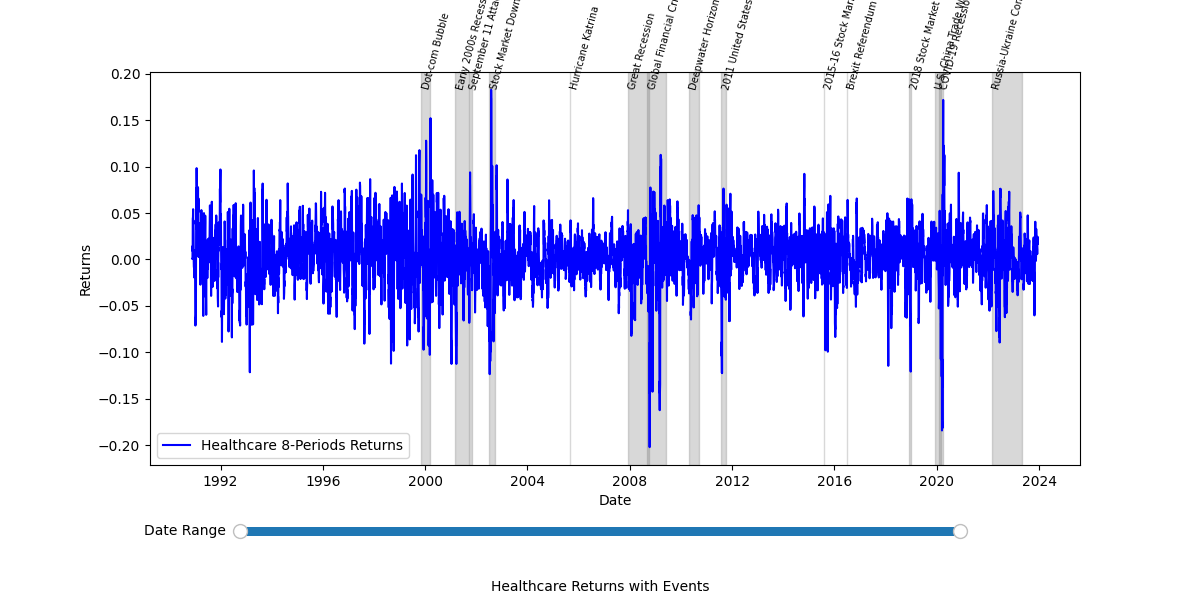

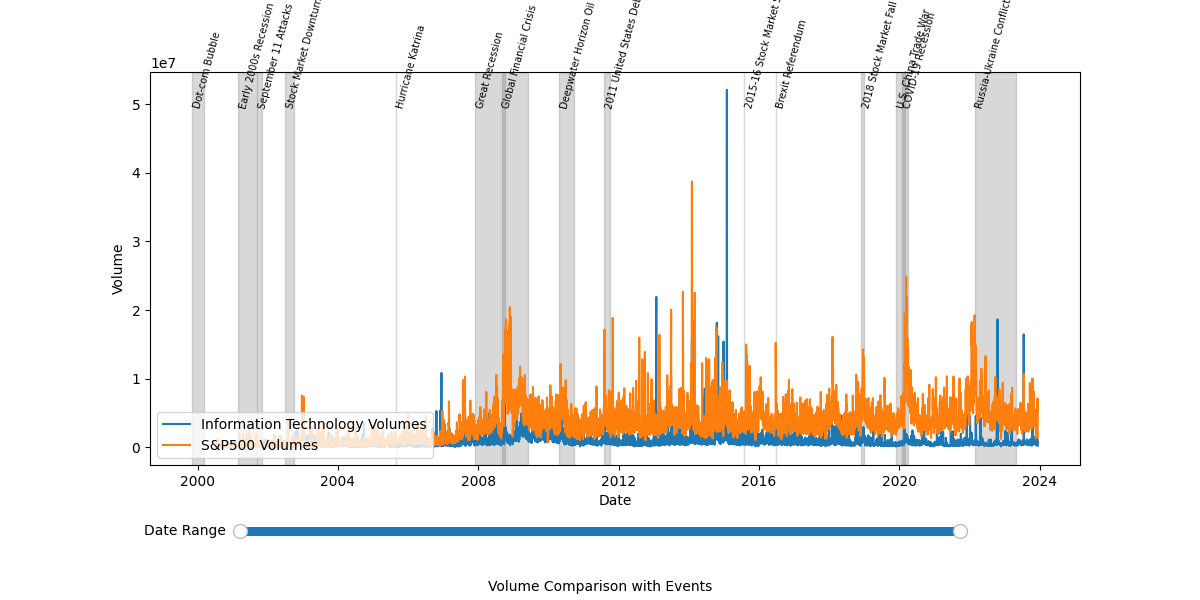

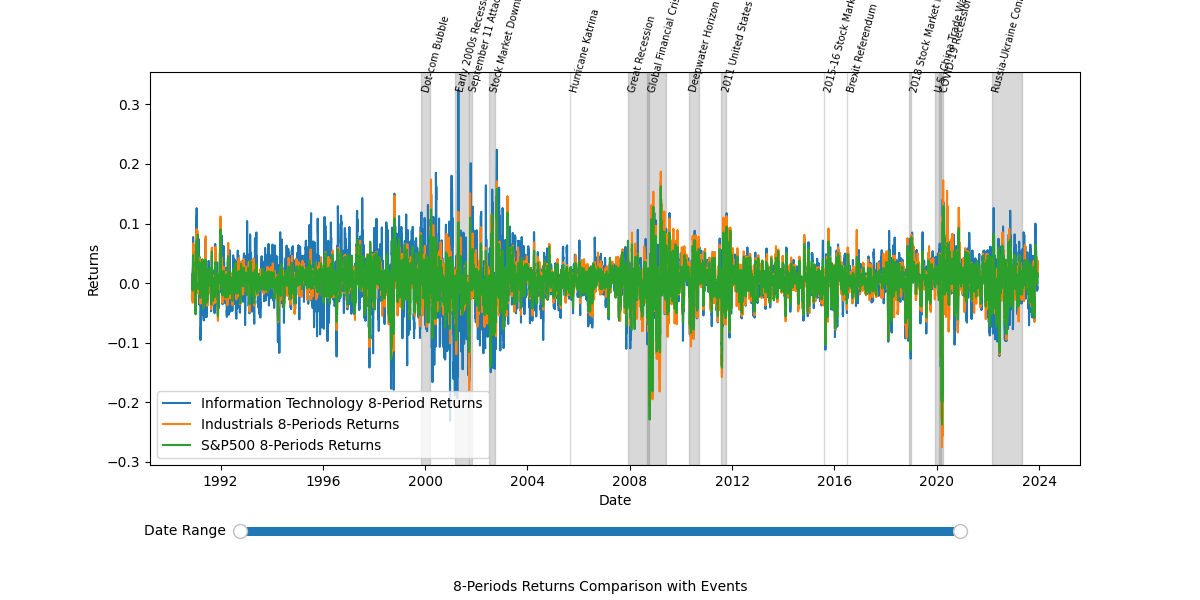

In [10]:
Healthcare = IndustryAnalysis("Healthcare")
Healthcare.plot_all("Returns", period=8)

IT = IndustryAnalysis("Information Technology")
IT.compare_volumes('S&P500')
IT.compare_returns(8,'Industrials', 'S&P500')
#IT.compare_moving_averages(10,'Utilities')

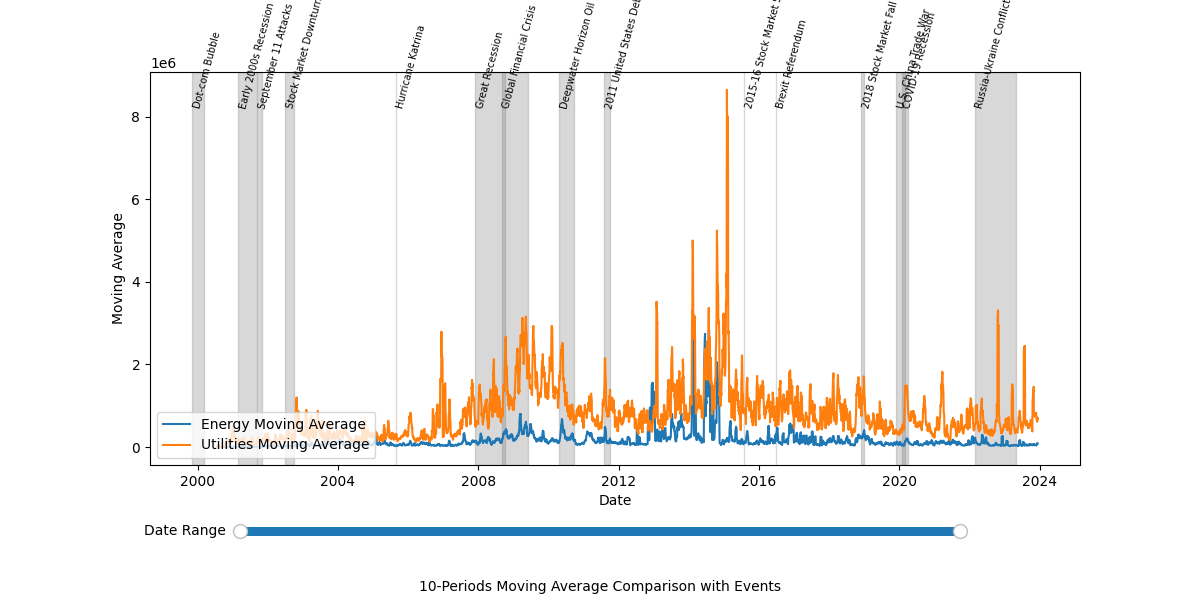

In [ ]:
EE = IndustryAnalysis("Energy")
#Healthcare = IndustryAnalysis("Healthcare")

#IT.calc_period_returns()
#Healthcare.plot_all("Returns", period=8)

#IT.compare_volumes('S&P500')
#IT.compare_returns(8,'Industrials', 'S&P500')
#EE.compare_moving_averages(10,'Utilities')

In [ ]:
#Healthcare = IndustryAnalysis("Healthcare")

#IT.calc_period_returns()
#Healthcare.plot_all("Returns", period=8)

#IT.compare_volumes('S&P500')
#IT.compare_returns(8,'Industrials', 'S&P500')